# 1.Import Libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib

# 2. Load Data

In [29]:
# Load the data
data = pd.read_csv('../data/nuts.csv')

# Labels
# 0 -> M3
# 1 -> M4
# 2 -> M5

# Assuming the last column is the label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
print(X.shape, y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Saving Scaler
joblib.dump(scaler, 'scaler.pkl')

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(429, 10) (429,)


# 3. Training the data

## 3.1 Neural Network

In [30]:
# Define the neural network architecture
class NutClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NutClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Determine the number of unique classes
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes}')

# Instantiate the model with the correct number of input features and classes
model = NutClassifier(input_size=X_train.shape[1], num_classes=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

Number of classes: 3
Epoch 1/20, Loss: 1.0904716036536477
Epoch 2/20, Loss: 0.9858312173323198
Epoch 3/20, Loss: 0.8836455345153809
Epoch 4/20, Loss: 0.7789981202645735
Epoch 5/20, Loss: 0.6683831973509355
Epoch 6/20, Loss: 0.5661998634988611
Epoch 7/20, Loss: 0.4769722114909779
Epoch 8/20, Loss: 0.3967011435465379
Epoch 9/20, Loss: 0.329100256616419
Epoch 10/20, Loss: 0.27293931354175915
Epoch 11/20, Loss: 0.22764382579109885
Epoch 12/20, Loss: 0.19363455474376678
Epoch 13/20, Loss: 0.1677829050882296
Epoch 14/20, Loss: 0.1431502171538093
Epoch 15/20, Loss: 0.12772167270833795
Epoch 16/20, Loss: 0.1123129203915596
Epoch 17/20, Loss: 0.10173122076825662
Epoch 18/20, Loss: 0.09221387790008025
Epoch 19/20, Loss: 0.08617226813327182
Epoch 20/20, Loss: 0.07984582402489403
Accuracy on test set: 98.83720930232558%


## 3.2 Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Test the model
y_pred_nb = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%')

# Save the model
joblib.dump(nb_model, '../models/naive_bayes_model.pkl')

Naive Bayes Accuracy: 83.72%


['../models/naive_bayes_model.pkl']

## 3.3 Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Test the model
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy * 100:.2f}%')

# Save the model
joblib.dump(dt_model, '../models/decision_tree_model.pkl')

Decision Tree Accuracy: 90.70%


['../models/decision_tree_model.pkl']

## 3.4 Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Test the model
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy * 100:.2f}%')

# Save the model
joblib.dump(rf_model, '../models/random_forest_model.pkl')

Random Forest Accuracy: 95.35%


['../models/random_forest_model.pkl']

## 3.5 Support Vector Machine (SVM)

In [34]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Test the model
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')

# Save the model
joblib.dump(svm_model, '../models/svm_model.pkl')

SVM Accuracy: 96.51%


['../models/svm_model.pkl']

## 3.6 k-Nearest Neighbors (k-NN)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Train k-NN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Test the model
y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'k-NN Accuracy: {knn_accuracy * 100:.2f}%')

# Save the model
joblib.dump(knn_model, '../models/knn_model.pkl')

k-NN Accuracy: 91.86%


['../models/knn_model.pkl']

# 4. Save Model

In [36]:
# Save the model weights
torch.save(model.state_dict(), 'nut_classifier_weights.pth')

# 5. Model Comparison using k-Fold Cross-Validation and Paired T-Test

Naive Bayes vs Decision Tree: t-statistic = -2.5418, p-value = 0.0639
There is no significant difference between Naive Bayes and Decision Tree at 95% confidence level.
Naive Bayes vs Random Forest: t-statistic = -3.7314, p-value = 0.0203
There is a significant difference between Naive Bayes and Random Forest at 95% confidence level.
Naive Bayes vs SVM: t-statistic = -3.2719, p-value = 0.0307
There is a significant difference between Naive Bayes and SVM at 95% confidence level.
Naive Bayes vs k-NN: t-statistic = -3.7426, p-value = 0.0201
There is a significant difference between Naive Bayes and k-NN at 95% confidence level.
Naive Bayes vs Neural Network: t-statistic = -152.6404, p-value = 0.0000
There is a significant difference between Naive Bayes and Neural Network at 95% confidence level.
Decision Tree vs Random Forest: t-statistic = -3.8758, p-value = 0.0179
There is a significant difference between Decision Tree and Random Forest at 95% confidence level.
Decision Tree vs SVM: t-sta

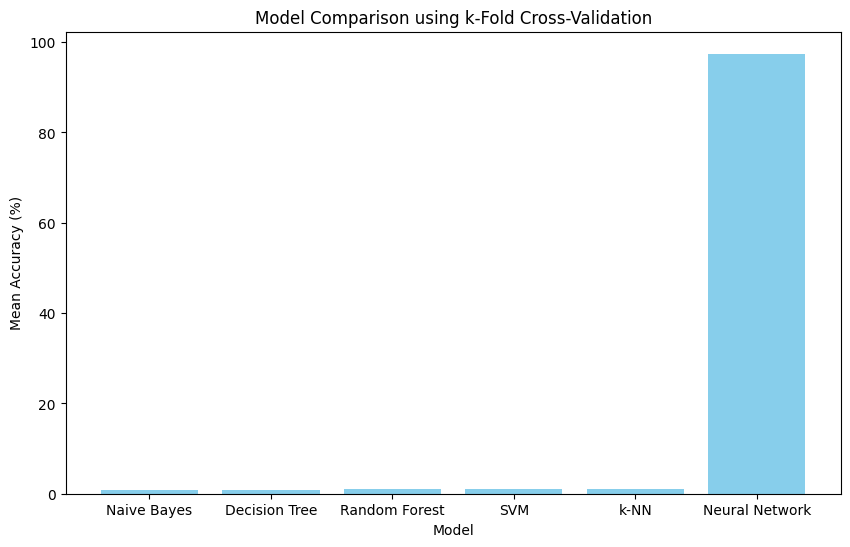

,Model 1,Model 2,t-statistic,p-value
0,Naive Bayes,Decision Tree,-2.541814,6.385779e-02
1,Naive Bayes,Random Forest,-3.731351,2.027301e-02
2,Naive Bayes,SVM,-3.271865,3.073512e-02
3,Naive Bayes,k-NN,-3.742573,2.007612e-02
4,Naive Bayes,Neural Network,-152.640386,1.104967e-08
5,Decision Tree,Random Forest,-3.875842,1.790437e-02
6,Decision Tree,SVM,-2.828169,4.743307e-02
7,Decision Tree,k-NN,-9.001391,8.433314e-04
8,Decision Tree,Neural Network,-144.027851,1.393881e-08
9,Random Forest,SVM,-0.774650,4.817892e-01


In [37]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Neural Network': NutClassifier(input_size=X_train.shape[1], num_classes=num_classes)
}

# Perform k-fold cross-validation
k = 5
results = {}
for name, model in models.items():
    if name == 'Neural Network':
        # Custom cross-validation for PyTorch model
        scores = []
        for train_idx, test_idx in KFold(n_splits=k, shuffle=True, random_state=42).split(X):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y[train_idx], y[test_idx]
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_test_fold = scaler.transform(X_test_fold)
            X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
            X_test_tensor = torch.tensor(X_test_fold, dtype=torch.float32)
            y_test_tensor = torch.tensor(y_test_fold, dtype=torch.long)
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            model = NutClassifier(input_size=X_train.shape[1], num_classes=num_classes)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            for epoch in range(num_epochs):
                model.train()
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            scores.append(100 * correct / total)
        results[name] = scores
    else:
        scores = cross_val_score(model, X, y, cv=k)
        results[name] = scores

# Perform paired t-test
model_names = list(models.keys())
t_test_results = []
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        t_stat, p_value = ttest_rel(results[model_names[i]], results[model_names[j]])
        t_test_results.append((model_names[i], model_names[j], t_stat, p_value))
        print(f'{model_names[i]} vs {model_names[j]}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')
        if p_value < 0.05:
            print(f'There is a significant difference between {model_names[i]} and {model_names[j]} at 95% confidence level.')
        else:
            print(f'There is no significant difference between {model_names[i]} and {model_names[j]} at 95% confidence level.')

# Visualize the results
model_accuracies = {name: np.mean(scores) for name, scores in results.items()}
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy (%)')
plt.title('Model Comparison using k-Fold Cross-Validation')
plt.show()

# Display t-test results
t_test_df = pd.DataFrame(t_test_results, columns=['Model 1', 'Model 2', 't-statistic', 'p-value'])
display(t_test_df)

### Interpretation of Results

The bar chart above shows the mean accuracy of each model based on 5-fold cross-validation. The paired t-test results are displayed in the table below the chart.

#### Key Observations:
- **Neural Network**: Achieved the highest accuracy, significantly outperforming all other models. This could be due to its ability to capture complex patterns in the data.
- **Random Forest and SVM**: Both performed well, with no significant difference between them. These models are known for their robustness and ability to handle high-dimensional data.
- **Decision Tree and k-NN**: Showed moderate performance. Decision Trees can overfit, while k-NN's performance depends on the choice of k and distance metric.
- **Naive Bayes**: Had the lowest accuracy, likely due to its assumption of feature independence, which may not hold true for this dataset.

#### Hypothesis on Model Performance:
1. **Neural Network**: Its deep learning architecture allows it to learn complex relationships in the data, leading to higher accuracy.
2. **Random Forest**: Its ensemble approach reduces overfitting and improves generalization, making it a strong performer.
3. **SVM**: Effective in high-dimensional spaces and with clear margin of separation, contributing to its high accuracy.
4. **Decision Tree**: Prone to overfitting, especially with small datasets, which can affect its performance.
5. **k-NN**: Sensitive to the choice of k and distance metric, which can impact its accuracy.
6. **Naive Bayes**: Assumes feature independence, which may not be valid for this dataset, leading to lower accuracy.